# Sq4S Analysis

Jupyter notebook for the analysis of radial updates in the context of the two-site Hubbard model.  
Naturally, utilizing this notebook requires access to the data and the path has to be provided in the next cell.  
While this notebook should suffice to recreate all the analysis steps starting from the raw data (i.e. the files given in "Sq4S/data"), actually running all of the postprocessing steps will take quite a lot of time. Therefore, the intermediate postprocessed data is already provided in "Sq4S/postpro_data".  

### Specifiy glob_path to link to the data folder

In [1]:
glob_path = ""

data_path = glob_path + "Sq4S/data/"
postpro_path = glob_path + "Sq4S/postpro_data/"
plot_path = glob_path + "Sq4S/plots/"

### Import modules and necessary custom functions

In [2]:
### Import modules
import numpy as np
import matplotlib.pyplot as plt
import h5py
import pandas as pd
from functools import partial
import os
import time
%matplotlib inline

# ### Import custom functions
from utils import save_arrays, round_to_n, round_to_n_of_err, get_parentheses_error_notation, sep, get_NSL_lattices_from_h5#, get_NSL_correlators_from_h5
from observable_funcs import load_comp_save_obs, mean_obs, abs_mean_obs, compute_time_slice_radius, compute_radius
from analysis_funcs import full_ac_fits, ac_analysis_detM, plot_and_fit_sigmin, Nt_autocorrelation_analysis, get_NSL_Sq4S_correlators_from_h5, Sq4S_correlator_autocorr_analysis

### Define custom colors for plotting
my_blue = (2/255, 61/255, 107/255)
my_red = (217/255, 85/255, 20/255)
my_green = (163/255, 201/255, 0/255)
my_violet = (100/255, 2/255, 107/255)
my_brown = (107/255, 47/255, 2/255)
cs = [my_blue, my_red, my_green, my_violet, my_brown, "tab:blue", "tab:green", "tab:orange", "tab:red"]

### Information on all performed simulations, necessary to locate and identify files.

In [3]:
sig_Nt1 = [0.0, 0.1, 0.2, 0.3, 0.35, 0.4, 0.45, 0.5, 0.55, 0.6, 0.65, 0.7, 0.75, 0.8, 0.85, 0.9, 0.95, 1.0, 
           1.1, 1.2, 1.3, 1.4, 1.5, 1.6, 1.7, 1.8, 1.9, 2.0, 2.2, 2.4, 2.6, 2.8, 3.0, 3.5, 4.0]
sig_Nt4 = [0.0, 0.02, 0.04, 0.06, 0.07, 0.08, 0.09, 0.1, 
           0.12, 0.14, 0.16, 0.18, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 
           0.6, 0.7, 0.8, 0.9, 1.0, 1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0]
sig_Nt8 = [0.0, 0.02, 0.04, 0.045, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 
           0.12, 0.15, 0.17, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 
           1.2, 1.4, 1.6, 1.8, 2.0, 2.5, 3.0]
sig_Nt16 = [0.0, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.09, 0.1, 
            0.15, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 1.0, 1.5, 2.0, 2.5, 3.0]
sig_Nt32 = [0.0, 0.02, 0.025, 0.03, 0.04, 0.05, 0.06, 0.07, 0.08, 0.1, 0.2, 0.3, 0.4, 0.6, 0.8, 1.0, 1.5, 2.0, 2.5, 3.0]
sig_Nt40 = [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07, 0.1, 0.15, 0.2, 0.3, 0.4, 0.5, 0.7, 1.0, 1.5, 2.0]

# Dictionary with all simulations
sim_dict = {}
sim_dict[f"Nt1"] = {"Nmd" : 60, "Nconf" : int(3e5), "sigma" : sig_Nt1}
sim_dict[f"Nt4"] = {"Nmd" : 60, "Nconf" : int(3e5), "sigma" : sig_Nt4}
sim_dict[f"Nt8"] = {"Nmd" : 50, "Nconf" : int(3e5), "sigma" : sig_Nt8}
sim_dict[f"Nt16"] = {"Nmd" : 50, "Nconf" : int(3e5), "sigma" : sig_Nt16}
sim_dict[f"Nt32"] = {"Nmd" : 50, "Nconf" : int(4e5), "sigma" : sig_Nt32}
sim_dict[f"Nt40"] = {"Nmd" : 55, "Nconf" : int(4e5), "sigma" : sig_Nt40}


# Data postprocessing

### Compute observables

In [22]:
Nt_ = [1, 4, 8, 16, 32, 40]

t1 = time.time()
for Nt in Nt_:
    obs_dict = {"mean" : mean_obs, 
                "radius" : compute_radius, 
                "TimeSliceRadius" : partial(compute_time_slice_radius, Nt = Nt, Nx = 4)}
    sig_ = sim_dict[f"Nt{Nt}"]["sigma"]
    Nconf = sim_dict[f"Nt{Nt}"]["Nconf"]
    Nmd = sim_dict[f"Nt{Nt}"]["Nmd"]
    for sig in sig_:
        path = data_path + f"Nt{Nt}/Radial_Sq4Site_Nt{Nt}_sig"+str(sig).replace(".", "")+f"_Nmd{Nmd}.h5"
        csv_path = postpro_path + f"Nt{Nt}/Sq4S_Nt{Nt}_sig"+str(sig).replace(".", "p")+"_obs.csv"
        load_comp_save_obs(path, obs_dict, Nconf_max = Nconf, csv_path = csv_path)
    print(f"Nt={Nt} done after {round(time.time()-t1, 2)}s")

Nt=1 done after 117.22s


### Autocorrelation analysis for previously computed observables.  
Careful, plotting results will lead to a lot of plots. 

In [7]:
Nt_ = [1, 4, 8, 16, 32, 40]

for Nt in Nt_:
    Nt_autocorrelation_analysis(Nt = Nt, 
                                    sig_ = sim_dict[f"Nt{Nt}"]["sigma"], 
                                    analysis_name = "Sq4S", 
                                    postpro_path = postpro_path, 
                                    plot_path = plot_path, 
                                    plot_results = False)

### Autocorrelation analysis for correlators.  
Compute integrated autocorrelation time for all components of correlators

In [7]:
Nt_ = [1, 4, 8, 16, 32, 40]

split_subplots_dict = {"Nt1" : (1,1), "Nt4" : (2,2), "Nt8" : (2,4), "Nt16" : (4,4), "Nt32" : (4,8), "Nt40" : (5,8)}
show_plots = True

for Nt in Nt_:
    sig_ = sim_dict[f"Nt{Nt}"]["sigma"]
    Nconf_max = sim_dict[f"Nt{Nt}"]["Nconf"]
    Nmd = sim_dict[f"Nt{Nt}"]["Nmd"]
    n_corr = 2
    sn1, sn2 = split_subplots_dict[f"Nt{Nt}"]

    data = np.zeros((2, len(sig_), Nt, 4, 5))
    t1 = time.time()
    for i, sig in enumerate(sig_):
        path = data_path + f"Nt{Nt}/Radial_Sq4Site_Nt{Nt}_sig"+str(sig).replace(".", "")+f"_Nmd{Nmd}.h5"
        full_corr = np.real(get_NSL_Sq4S_correlators_from_h5(path, Nt, Nconf_max))
        for k_ind in range(4):
            tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_ = Sq4S_correlator_autocorr_analysis(full_corr[:, :, k_ind], 
                                                                                                     Nt = Nt, split_n1 = sn1, split_n2 = sn2, 
                                                                                                     S = 1.0, 
                                                                                                     use_first_zero_crossing = False, 
                                                                                                     save_plot = plot_path + f"ac/Nt{Nt}/Sq4S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_k{k_ind}_ac_S1", 
                                                                                                     suptitle = rf"$\sigma_R = {sig}$; $N_t={Nt}$; $S=1$")
            save_fname = postpro_path + f"Nt{Nt}/Sq4S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_k{k_ind}_ac_S1.txt"
            save_arrays(save_fname, ["obs", "stderr", "tint", "dtint", "W"], False, tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_)
            ac_crit_ind = 0
            data[ac_crit_ind, i, :, k_ind, 0], data[ac_crit_ind, i, :, k_ind, 1], data[ac_crit_ind, i, :, k_ind, 2], data[ac_crit_ind, i, :, k_ind, 3], data[ac_crit_ind, i, :, k_ind, 4] = tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_

            tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_ = Sq4S_correlator_autocorr_analysis(full_corr[:, :, k_ind], 
                                                                                                     Nt = Nt, split_n1 = sn1, split_n2 = sn2, 
                                                                                                     S = 1.0, 
                                                                                                     use_first_zero_crossing = True, 
                                                                                                     save_plot = plot_path + f"ac/Nt{Nt}/Sq4S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_k{k_ind}_ac_zc", 
                                                                                                     suptitle = rf"$\sigma_R = {sig}$; $N_t={Nt}$; zero-crossing")
            save_fname = postpro_path + f"Nt{Nt}/Sq4S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_k{k_ind}_ac_zc.txt"
            save_arrays(save_fname, ["obs", "stderr", "tint", "dtint", "W"], False, tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_)
            ac_crit_ind = 1
            data[ac_crit_ind, i, :, k_ind, 0], data[ac_crit_ind, i, :, k_ind, 1], data[ac_crit_ind, i, :, k_ind, 2], data[ac_crit_ind, i, :, k_ind, 3], data[ac_crit_ind, i, :, k_ind, 4] = tmp_obs_, tmp_stderr_, tmp_tint_, tmp_dtint_, tmp_W_
        print(f"Sigma {sig} done after {round(time.time()-t1, 2)}s. ")
    print(f"Nt={Nt} done after {round(time.time()-t1, 2)}s. ")
    sep()




Reduce integrated autocorrelation times to a single value for the correlator

In [10]:
ac_crits = ["S1", "zc"]
Nt_ = [1, 4, 8, 16, 32, 40]


header = ["sig", "tint_k0", "dtint_k0", "tint_k1", "dtint_k1", "tint_k2", "dtint_k2", "tint_k3", "dtint_k3"]
# for new_ind, (ac_key, ac_label) in enumerate(ac_crits.items()):
for j, Nt in enumerate(Nt_):
    Nt_key = f"Nt{Nt}"
    sig_ = sim_dict[f"Nt{Nt}"]["sigma"]
    N_sig = len(sig_)
    save_tint_max = np.zeros((2, 4, N_sig))
    save_dtint_max = np.zeros((2, 4, N_sig))
    save_tint_mean = np.zeros((2, 4, N_sig))
    save_dtint_mean = np.zeros((2, 4, N_sig))
    
    for sig_ind, sig in enumerate(sig_):
        for k_ind in range(4):
            for ac_ind, ac_name in enumerate(ac_crits):
                path = postpro_path + f"Nt{Nt}/Sq4S_Nt{Nt}_sig"+str(sig).replace(".", "p")+f"_k{k_ind}_ac_" + ac_name + ".txt"
                tint_tmp, dtint_tmp = np.loadtxt(path, usecols = (2, 3), skiprows = 1, unpack = True)
                
                lvals = 1 if Nt==1 else dtint_tmp.shape[0]
                max_ind = np.argmax(tint_tmp).item()
                save_tint_max[ac_ind, k_ind, sig_ind] = tint_tmp if Nt==1 else tint_tmp[max_ind]
                save_dtint_max[ac_ind, k_ind, sig_ind] = dtint_tmp if Nt==1 else dtint_tmp[max_ind]
                save_tint_mean[ac_ind, k_ind, sig_ind] = np.mean(tint_tmp)
                save_dtint_mean[ac_ind, k_ind, sig_ind] = np.sqrt(np.sum(np.power(dtint_tmp, 2)))/lvals

    
    for ac_ind, ac_name in enumerate(ac_crits):
        save_path = postpro_path + f"Nt{Nt}/Sq4S_Nt{Nt}_ac_"+ac_name+"_rc_mean.txt"
        save_arrays(save_path, header, False, sig_, save_tint_mean[ac_ind, 0, :], save_dtint_mean[ac_ind, 0, :], save_tint_mean[ac_ind, 1, :], save_dtint_mean[ac_ind, 1, :], save_tint_mean[ac_ind, 2, :], save_dtint_mean[ac_ind, 2, :], save_tint_mean[ac_ind, 3, :], save_dtint_mean[ac_ind, 3, :])

        save_path = postpro_path + f"Nt{Nt}/Sq4S_Nt{Nt}_ac_"+ac_name+"_rc_max.txt"
        save_arrays(save_path, header, False, sig_, save_tint_max[ac_ind, 0, :], save_dtint_max[ac_ind, 0, :], save_tint_max[ac_ind, 1, :], save_dtint_max[ac_ind, 1, :], save_tint_max[ac_ind, 2, :], save_dtint_max[ac_ind, 2, :], save_tint_max[ac_ind, 3, :], save_dtint_max[ac_ind, 3, :])
        

### Autocorrelation analysis for sgndetM observable. 

In [6]:
Nt_ = [1, 4, 8, 16, 24, 32, 40]

def get_data_string(sig, Nt, Nmd, data_path):
    return data_path + f"Nt{Nt}/Radial_Sq4Site_Nt{Nt}_sig"+str(sig).replace(".", "")+f"_Nmd{Nmd}_detM.txt"


for i, Nt in enumerate(Nt_):
    sig_ = sim_dict[f"Nt{Nt}"]["sigma"]
    Nmd = sim_dict[f"Nt{Nt}"]["Nmd"]
    partial_get_data_string = partial(get_data_string, Nt = Nt, Nmd = Nmd, data_path = data_path)
    ac_data_array = ac_analysis_detM(Nt = Nt, 
                                     data_str_f = partial_get_data_string, 
                                     sig_ = sig_, 
                                     analysis_name = "Sq4S", 
                                     postpro_path = postpro_path, 
                                     plot_path = plot_path, 
                                     plot_results = False)


# Integrated autocorrelation time fits; $\tau_{\mathrm{int}}(\sigma_R)=a\sigma_R^{-2} + b + c\sigma_R$

Dictionaries with functions to get the data and information on fitting procedure.

In [4]:
Sq4S_acfit_dict = {}

radius_name = r"$\mathcal{O}_\Phi=\sqrt{\sum_x \left(\sum_t\phi_{tx}\right)^2}$"
charge_name = r"$\mathcal{O}_Q=\sum_{t,x} \phi_{tx}/d$"
corr_name0 = r"$\mathcal{O}_{C_0}=C_{k_0}(\tau)$"
corr_name1 = r"$\mathcal{O}_{C_1}=C_{k_1}(\tau)$"
corr_name2 = r"$\mathcal{O}_{C_2}=C_{k_2}(\tau)$"
corr_name3 = r"$\mathcal{O}_{C_3}=C_{k_3}(\tau)$"
sgndetM_name = r"$\mathcal{O}_f=\mathrm{sgn} f[i\phi]$"

def get_tsradius_data(Nt, ac_name, postpro_path):
    path = postpro_path + f"Nt{Nt}/ac_data_"+ac_name+f"_Nt{Nt}_TimeSliceRadius.csv"
    df = pd.read_csv(path)
    data = df.to_numpy()
    sigma, obs, stderr, tint, tinterr = data[:, 0], data[:, 1], data[:, 3], data[:, 5], data[:, 6]
    return (sigma, obs, stderr, tint, tinterr)

def get_charge_data(Nt, ac_name, postpro_path):
    path = postpro_path + f"Nt{Nt}/ac_data_"+ac_name+f"_Nt{Nt}_mean.csv"
    df = pd.read_csv(path)
    data = df.to_numpy()
    sigma, obs, stderr, tint, tinterr = data[:, 0], data[:, 1], data[:, 3], data[:, 5], data[:, 6]
    return (sigma, obs, stderr, tint, tinterr)

def get_corr_data(Nt, ac_name, rc_name, k, postpro_path):
    path = postpro_path + f"Nt{Nt}/Sq4S_Nt{Nt}_ac_"+ac_name+"_rc_"+rc_name+".txt"
    sigma, tint, tinterr = np.loadtxt(path, usecols = (0, 2*k+1, 2*k+2), skiprows = 1, unpack = True)
    obs, stderr = None, None
    return (sigma, obs, stderr, tint, tinterr)

def get_sgndetM_data(Nt, ac_name, postpro_path):
    path = postpro_path + f"Nt{Nt}/Sq4S_Nt{Nt}_detM_ac_"+ac_name+".txt"
    sigma, obs, stderr, tint, tinterr = np.loadtxt(path, usecols = (0, 1, 3, 5, 6), skiprows = 1, unpack = True)
    return (sigma, obs, stderr, tint, tinterr)
    
ac_name = "S1"
corr_ac_name = "zc"
rc_name = "max"

Nt = 1
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0, 1, 2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0, 1, 2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k0"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 0, postpro_path), "obs_name" : corr_name0, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k1"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 1, postpro_path), "obs_name" : corr_name1, "outlier_inds" : [0, 1, 2, 3, 4, 5, 6, 7], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k2"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 2, postpro_path), "obs_name" : corr_name2, "outlier_inds" : [0, 1, 2, 3, 4, 5, 6, 7], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k3"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 3, postpro_path), "obs_name" : corr_name3, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
Sq4S_acfit_dict[f"Nt{Nt}"] = tmp_dict

Nt = 4
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0, 1, 2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k0"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 0, postpro_path), "obs_name" : corr_name0, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k1"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 1, postpro_path), "obs_name" : corr_name1, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k2"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 2, postpro_path), "obs_name" : corr_name2, "outlier_inds" : [0, 1, 5, -6], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k3"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 3, postpro_path), "obs_name" : corr_name3, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
Sq4S_acfit_dict[f"Nt{Nt}"] = tmp_dict

Nt = 8
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k0"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 0, postpro_path), "obs_name" : corr_name0, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k1"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 1, postpro_path), "obs_name" : corr_name1, "outlier_inds" : [0, 1, 2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k2"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 2, postpro_path), "obs_name" : corr_name2, "outlier_inds" : [0, 1, 2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k3"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 3, postpro_path), "obs_name" : corr_name3, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
Sq4S_acfit_dict[f"Nt{Nt}"] = tmp_dict

Nt = 16
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k0"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 0, postpro_path), "obs_name" : corr_name0, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k1"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 1, postpro_path), "obs_name" : corr_name1, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k2"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 2, postpro_path), "obs_name" : corr_name2, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k3"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 3, postpro_path), "obs_name" : corr_name3, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
Sq4S_acfit_dict[f"Nt{Nt}"] = tmp_dict

Nt = 32
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0, 4, 6], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k0"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 0, postpro_path), "obs_name" : corr_name0, "outlier_inds" : [0, 3, 4, 6, 8, -1, -2, -3, -6], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k1"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 1, postpro_path), "obs_name" : corr_name1, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k2"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 2, postpro_path), "obs_name" : corr_name2, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k3"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 3, postpro_path), "obs_name" : corr_name3, "outlier_inds" : [0, 3, 4, 6, 8, -1, -2, -3, -6], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
Sq4S_acfit_dict[f"Nt{Nt}"] = tmp_dict

Nt = 40
tmp_dict = {}
tmp_dict["TimeSliceRadius"] = {"data" : get_tsradius_data(Nt, ac_name, postpro_path), "obs_name" : radius_name, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Charge"] = {"data" : get_charge_data(Nt, ac_name, postpro_path), "obs_name" : charge_name, "outlier_inds" : [0, -2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k0"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 0, postpro_path), "obs_name" : corr_name0, "outlier_inds" : [0, -2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k1"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 1, postpro_path), "obs_name" : corr_name1, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k2"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 2, postpro_path), "obs_name" : corr_name2, "outlier_inds" : [0], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["Correlator_k3"] = {"data" : get_corr_data(Nt, corr_ac_name, rc_name, 3, postpro_path), "obs_name" : corr_name3, "outlier_inds" : [0, -2], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
tmp_dict["sgndetM"] = {"data" : get_sgndetM_data(Nt, ac_name, postpro_path), "obs_name" : sgndetM_name, "outlier_inds" : [0, 1], "xticks" : None, "yticks" : None, "xlim" : None, "ylim" : None}
Sq4S_acfit_dict[f"Nt{Nt}"] = tmp_dict


### Perform the fits and get estimates on $\sigma_R^{(\mathrm{min})}$ and $\tau_{\mathrm{int}}^{(\mathrm{min})}$

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [2.14682087 3.70738873 1.80714532] [0.06681175 0.19165534 0.09305527]
Bootstrap fit [2.14689332 3.70461519 1.80926367] [0.04791593 0.1379124  0.06655201]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [ 2.02074953 10.75180567  7.8525115 ] [0.09877902 0.55009618 0.35292821]
Bootstrap fit [ 2.02090219 10.76285329  7.84605856] [0.08347592 0.46573712 0.30062548]


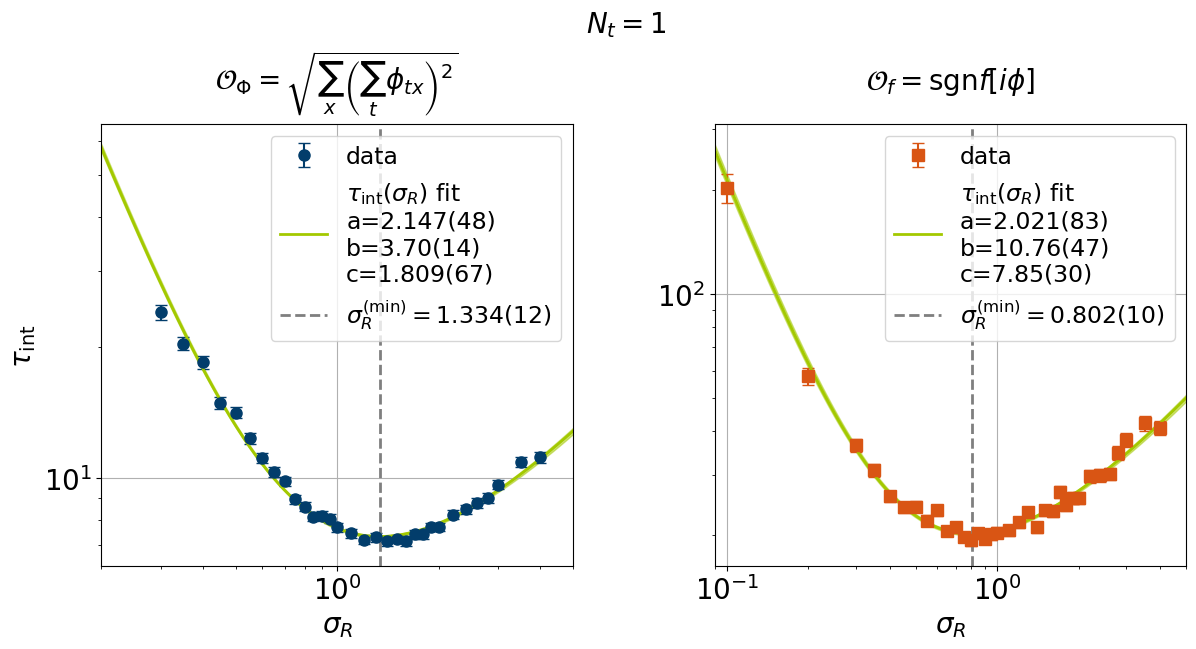

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [ 0.89443305 43.87766379 12.87807851] [0.06759455 2.54634996 2.39486493]
Bootstrap fit [ 0.89609125 43.79754275 12.97581987] [0.04020568 1.43947886 1.35456662]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [ 2.32230681 26.95395638 53.89702641] [0.09150593 2.21796788 2.54061655]
Bootstrap fit [ 2.3199513  26.9977452  53.92188978] [0.1080156  2.59851325 3.00442936]


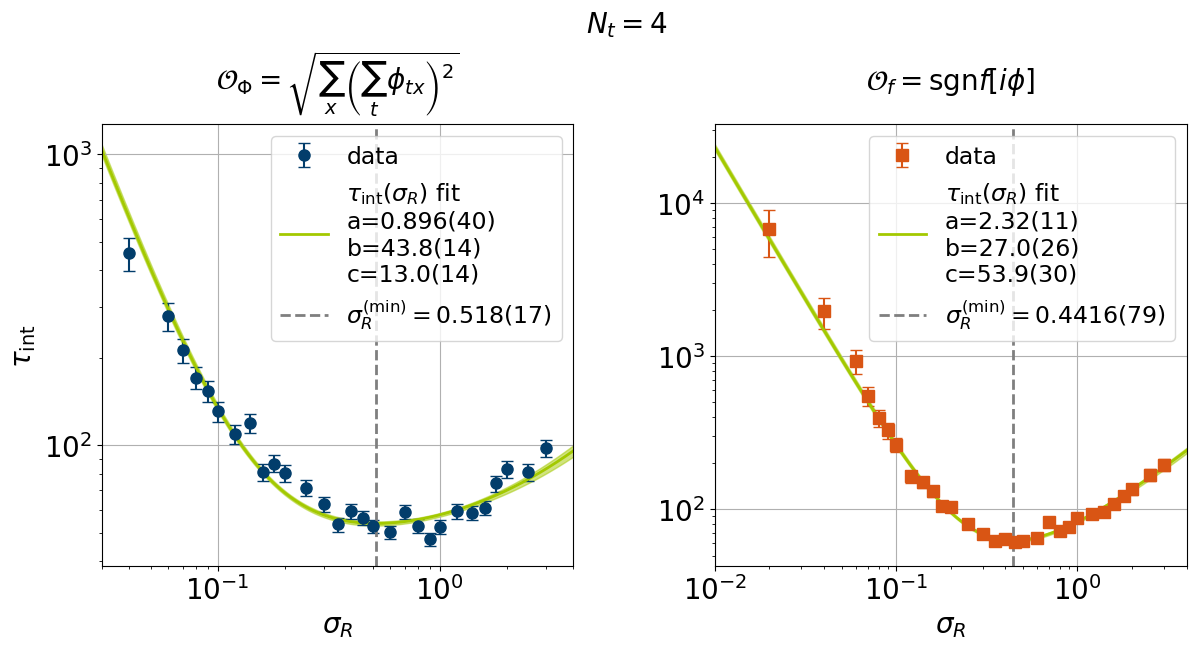

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [  0.69207496 128.1845401   43.6423219 ] [0.07760324 7.48633127 8.24742706]
Bootstrap fit [  0.68976229 128.22986888  43.80508122] [0.05072906 4.99931084 5.51496798]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [  3.37384131  49.45397865 166.14270321] [ 0.21602504  7.84577193 11.05765126]
Bootstrap fit [  3.36419997  49.52983525 166.43559903] [ 0.21481852  7.79228587 10.99782264]


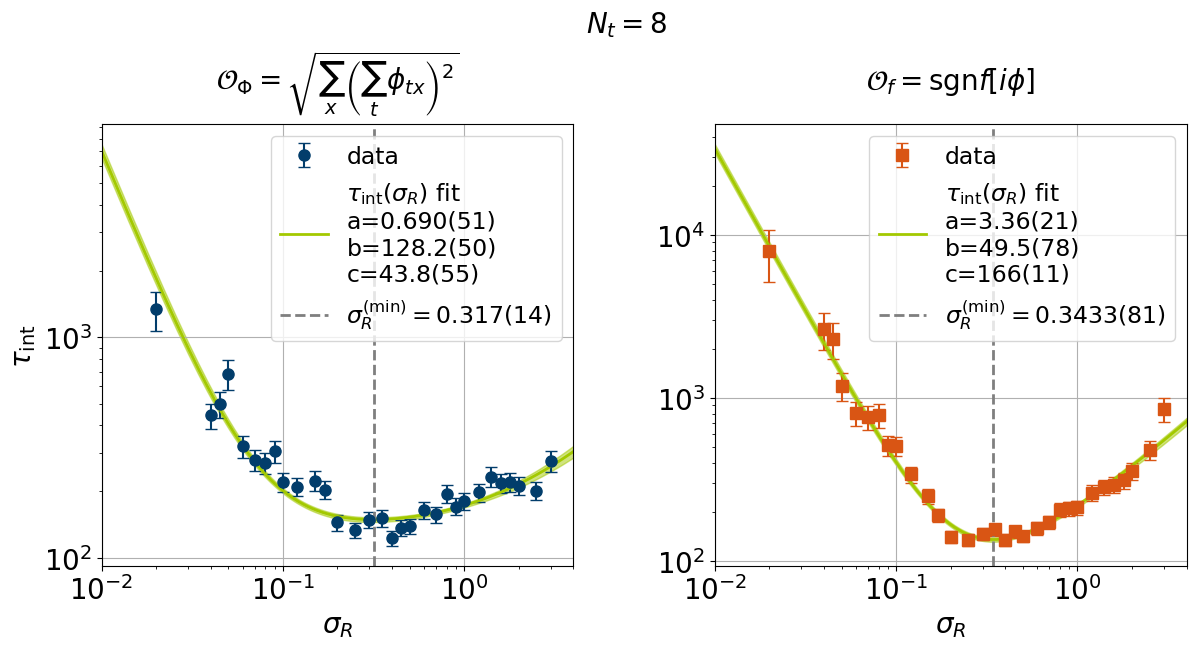

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [  0.90421076 227.26716516 107.3765853 ] [ 0.17236801 23.33038723 26.6331762 ]
Bootstrap fit [  0.90500063 227.53351883 107.55770277] [ 0.12410188 16.38609324 18.7327783 ]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [  4.38757593 112.59411065 475.98247129] [ 0.26154265 19.82369105 33.37594229]
Bootstrap fit [  4.39623069 111.51539393 479.15065195] [ 0.3883617  30.14072153 51.25901642]


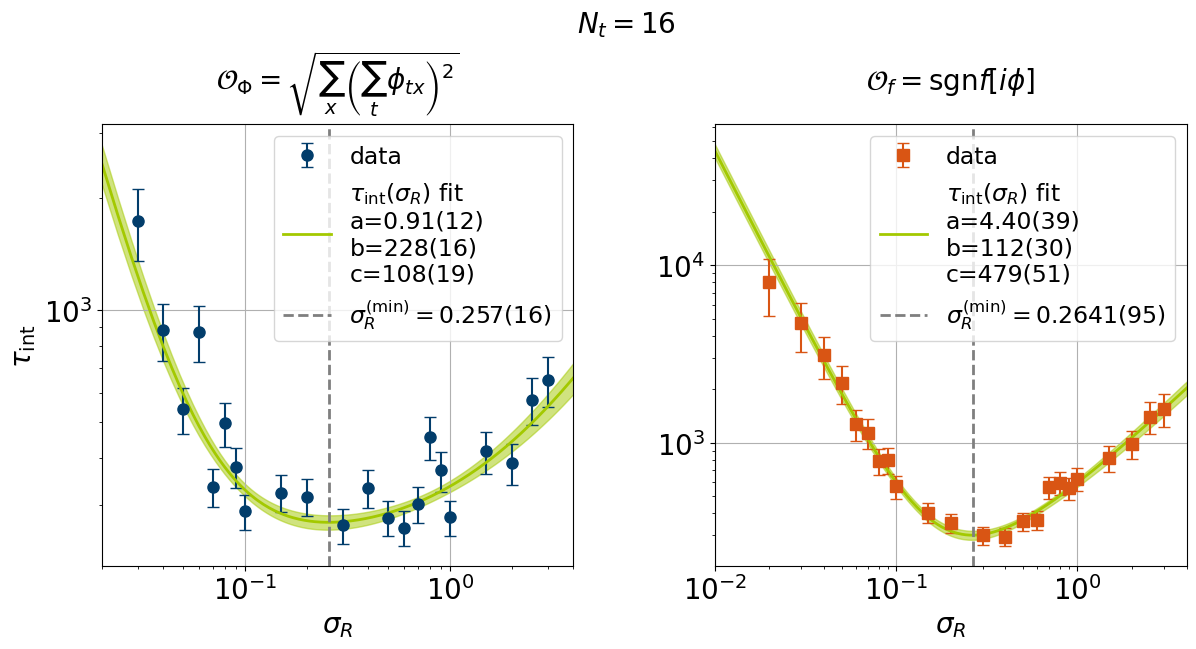

Fits skipped 8
Sigma min estimate 0.0 0.0
Curve fit [5.27551661e-01 6.00953914e+02 6.96281430e+01] [ 0.15046786 49.2443225  39.11824943]
Bootstrap fit [5.30975789e-01 6.00444336e+02 7.12017078e+01] [ 0.12434075 38.9353847  30.78988937]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [   4.3602064   466.95067325 1033.2055608 ] [  0.46964864  70.24923546 123.75177041]
Bootstrap fit [   4.38327626  465.04961226 1037.96056004] [  0.51169669  73.70573051 132.67737545]


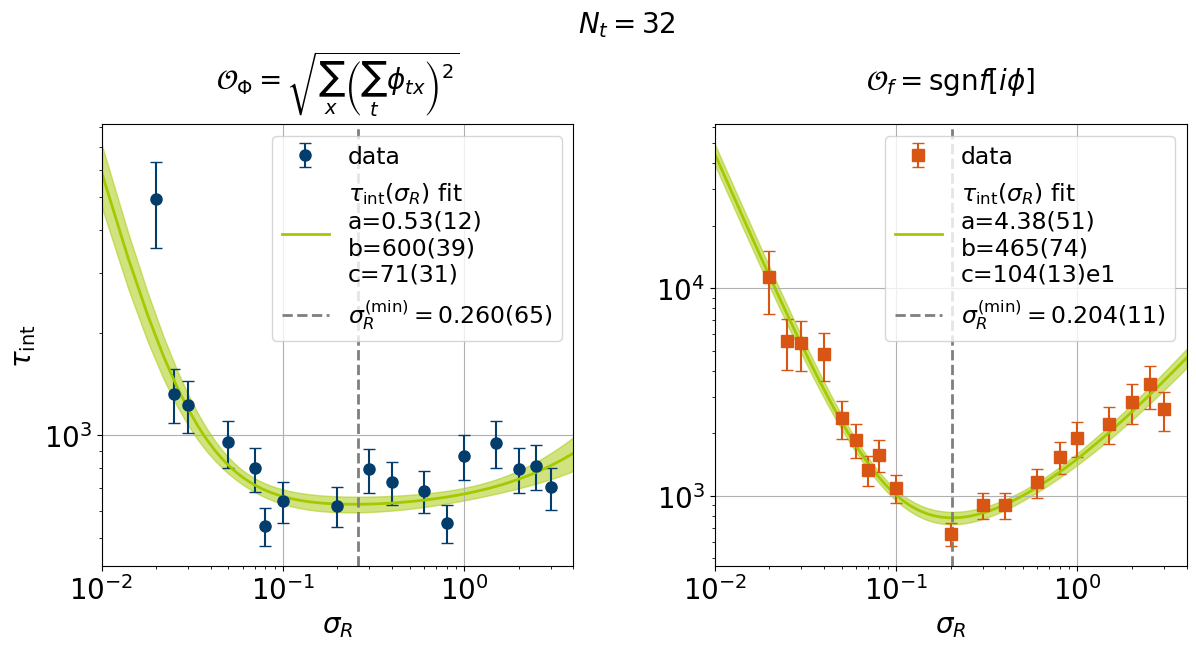

Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [3.51770370e-01 4.01120511e+02 2.24951763e+02] [ 0.0898706 47.1406335 85.0862293]
Bootstrap fit [3.51765542e-01 4.01379814e+02 2.26006467e+02] [ 0.05416205 27.98829416 51.65738957]
Fits skipped 0
Sigma min estimate 0.0 0.0
Curve fit [   6.06910666  249.06230463 2219.14436913] [  0.5585782   92.49099156 253.24063513]
Bootstrap fit [   6.07574878  245.78563653 2234.36381538] [  0.81150752 134.74205361 365.01617814]


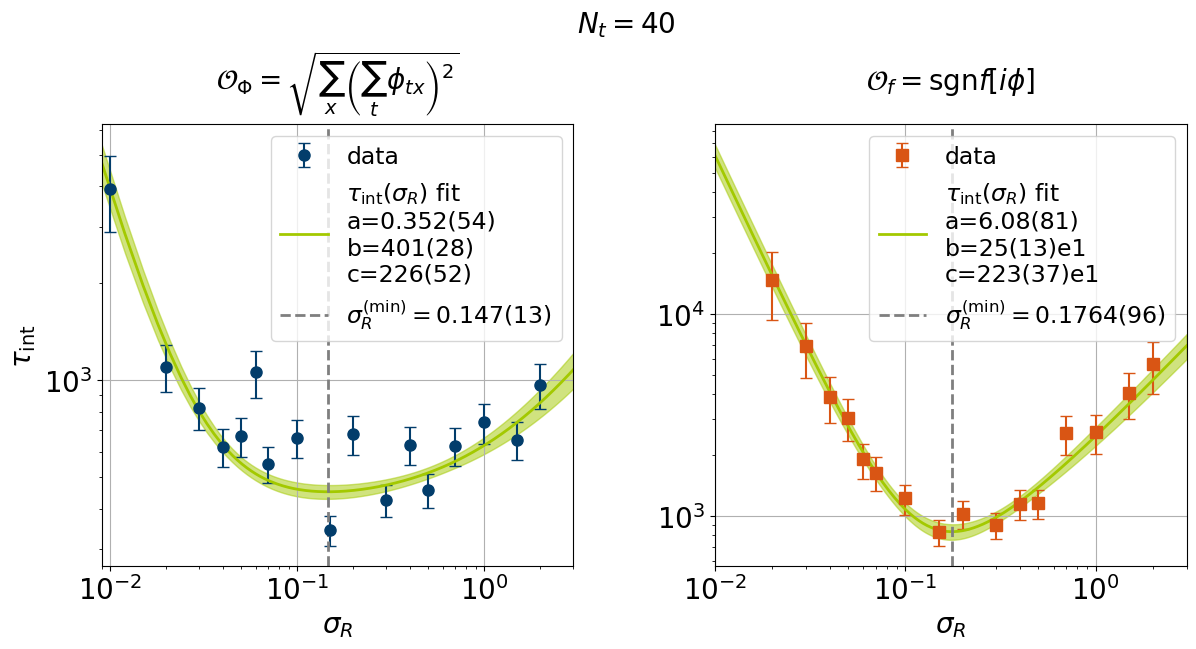

In [18]:
use_obs_dict = {"TimeSliceRadius" : True, 
                "Charge" : False, 
                "Correlator_k0" : False, 
                "Correlator_k1" : False, 
                "Correlator_k2" : False, 
                "Correlator_k3" : False, 
                "sgndetM" : True
                }

Nt_ = [1, 4, 8, 16, 32, 40]

plot_obs = False # Also plot observables themselves; Does not work for correlator
weight_fits = True # Weight fits with chi-squared
save_plots = False
save_data = False

smin_boot_, smin_err_, tintmin_boot_, tintmin_err_ = full_ac_fits(Nt_ = Nt_, 
                                                                 use_obs_dict = use_obs_dict, 
                                                                 acfit_dict = Sq4S_acfit_dict, 
                                                                 plot_path = plot_path, 
                                                                 analysis_name = "Sq4S", 
                                                                 plot_obs = plot_obs, 
                                                                 n_bootstrap = 1000, 
                                                                 weight_fits = weight_fits, 
                                                                 save_plots = save_plots)


data = np.stack((np.repeat(np.expand_dims(Nt_, axis = 0), smin_boot_.shape[0], axis = 0), smin_boot_, smin_err_, tintmin_boot_, tintmin_err_), axis = 0)
if save_data:
    column_names = ["Nt", "sigma_min", "sigma_min_err", "tauint_min", "tauint_min_err"]
    i = 0
    for obs_name, obs_bool in use_obs_dict.items():
        if obs_bool:
            data_dict = {}
            for k, col_name in enumerate(column_names):
                data_dict[col_name] = data[k, i, :]
            df = pd.DataFrame(data_dict)
            rc_string = ("_" + rc_name) if ("Correlator" in obs_name) else "" 
            csv_fname = postpro_path + f"Sq4S_smin_tintmin_"+obs_name+"_" + (corr_ac_name if ("Correlator" in obs_name) else ac_name) + rc_string + ("_weighted" if weight_fits else "") + ".csv"
            # df.to_csv(csv_fname, index = False)
            i+=1


### Scaling plots of $\sigma_R^{(\mathrm{min})}(d)$ and $\tau_{\mathrm{int}}^{(\mathrm{min})}(d)$ with corresponding fits.

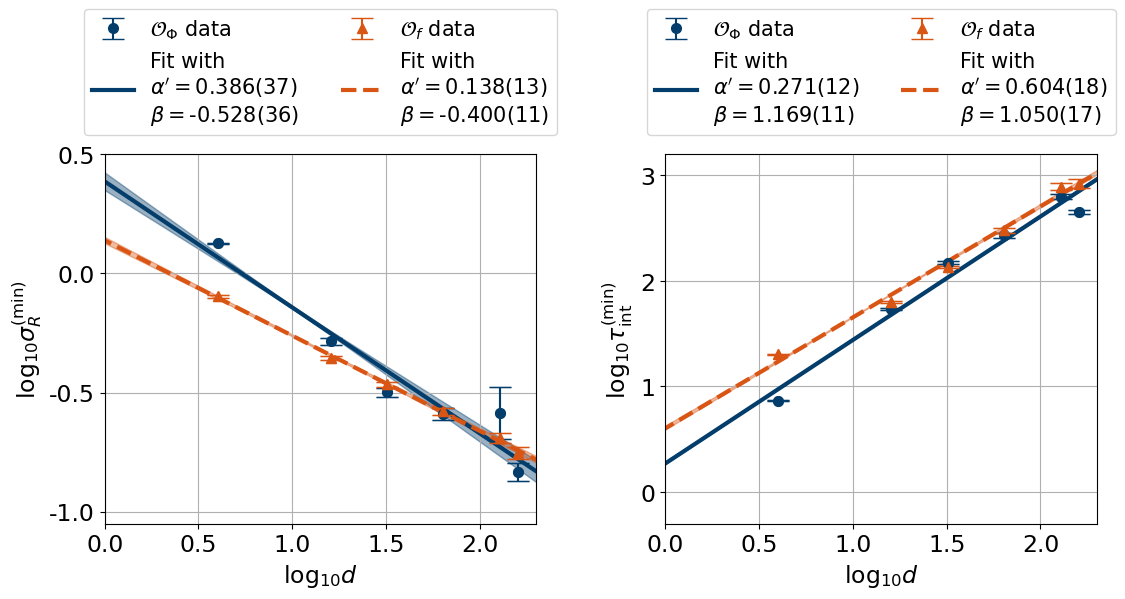

In [16]:
fs = 17 #24 with tex font
fs2 = 15 #19 with tex font
logfit = True

weight_fits = False

Nx = 4
use_obs_dict = {"TimeSliceRadius" : True, 
                "Charge" : False, 
                "Correlator_k0" : False, 
                "Correlator_k1" : False, 
                "Correlator_k2" : False, 
                "Correlator_k3" : False, 
                "sgndetM" : True
                }

lw = 3
n_bootstrap = 1000
ms = 7
capsize = 8

ac_type_names = ["S1", "zc"]
ac_name = ac_type_names[0]
fig, ax = plt.subplots(1, 2, figsize = (12.8, 4.8))

cax = ax[0]
if use_obs_dict["TimeSliceRadius"]:
    csv_path = postpro_path + f"Sq4S_smin_tintmin_TimeSliceRadius_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    d_ = np.multiply(Nx, Nt_)
    obs0_smin, obs0_smin_err = data[:, 1], data[:, 2]
    plot_and_fit_sigmin(cax, d_, obs0_smin, obs0_smin_err, n_bootstrap = n_bootstrap, color = cs[0], marker = "o", obs_name = r"$\mathcal{O}_\Phi$ data", logfit = logfit, weight_fits = weight_fits, lw = lw, markersize = ms, capsize = capsize)

if use_obs_dict["Charge"]:
    csv_path = postpro_path + f"Sq4S_smin_tintmin_Charge_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    d_ = np.multiply(Nx, Nt_)
    obs2_smin, obs2_smin_err = data[:, 1], data[:, 2]
    plot_and_fit_sigmin(cax, d_, obs2_smin, obs2_smin_err, n_bootstrap = n_bootstrap, color = cs[2], marker = "v", obs_name = r"$\mathcal{O}_Q$ data", logfit = logfit, weight_fits = weight_fits)

for k_ind in range(4):
    if use_obs_dict[f"Correlator_k{k_ind}"]:
        csv_path = postpro_path + f"Sq4S_smin_tintmin_Correlator_k{k_ind}_rc_max_zc_weighted.csv"
        df = pd.read_csv(csv_path)
        data = df.to_numpy()
        Nt_ = data[:, 0]
        smin, smin_err = data[:, 1], data[:, 2]
        d_ = np.multiply(Nx, Nt_)
        n_start  = 1
        plot_and_fit_sigmin(cax, d_, smin, smin_err, n_bootstrap = n_bootstrap, color = cs[1], marker = "s", obs_name = r"$C(t)$ data", logfit = logfit, weight_fits = weight_fits, n_start = n_start)

if use_obs_dict["sgndetM"]:
    csv_path = postpro_path + f"Sq4S_smin_tintmin_sgndetM_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    smin, smin_err = data[:, 1], data[:, 2]
    d_ = np.multiply(Nx, Nt_)
    n_start  = 0
    plot_and_fit_sigmin(cax, d_, smin, smin_err, n_bootstrap = n_bootstrap, color = cs[1], marker = "^", obs_name = r"$\mathcal{O}_f$ data", logfit = logfit, weight_fits = weight_fits, n_start = n_start, linestyle = "--", lw = lw, markersize = ms, capsize = capsize)


cax.grid()

handles, labels = cax.get_legend_handles_labels()
# print(handles, labels)

tmp_handles = [handles[2], handles[0], handles[3], handles[1]]
tmp_labels = [labels[2], labels[0], labels[3], labels[1]]

cax.legend(tmp_handles, tmp_labels, loc = "upper center", bbox_to_anchor = (0.5, 1.42), ncol = 2, fontsize = fs2)


cax.tick_params(axis='x', labelsize=fs)
cax.tick_params(axis='y', labelsize=fs)
if logfit:
    cax.set_xlim(0, 2.3)
    cax.set_ylim(-1.05, 0.5)
    cax.set_xlabel(r"$\log_{10} d$", fontsize = fs)
    cax.set_ylabel(r"$\log_{10} \sigma_R^{(\mathrm{min})}$", fontsize = fs)
    # cax.set_title(r"$\log_{10}\sigma_R^{(\mathrm{min})}(d) = \alpha' + \beta \log_{10} d$", fontsize = fs, pad = 15)
    tmp = [0.5, 0.0, -0.5, -1.0]
    cax.set_yticks(tmp, [str(x) for x in tmp])
else:
    cax.set_xlabel(r"$d=N_xN_t$", fontsize = fs)
    cax.set_ylabel(r"$\sigma_R^{(\mathrm{min})}$", fontsize = fs)
    cax.set_xscale("log")
    cax.set_yscale("log")
    cax.set_xlim(1, 200)
    cax.set_ylim(0.1, 3)
    cax.set_yticks([1e-1, 1e0])
    cax.set_xticks([1e0, 1e1, 1e2])
    cax.set_title(r"Fit $\sigma_R^{(\mathrm{min})}(d) = \alpha d^\beta$", fontsize = fs, pad = 15)

    
tau_at_sigmin = np.zeros((2, 6))
tau_at_sigmin_err = np.zeros((2, 6))

ac_type_names = ["S1", "zc"]
ac_name = ac_type_names[0]

cax = ax[1]

if use_obs_dict["TimeSliceRadius"]:
    csv_path = postpro_path + f"Sq4S_smin_tintmin_TimeSliceRadius_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    tau_at_sigmin[1], tau_at_sigmin_err[1] = data[:, 3], data[:, 4]
    d_ = np.multiply(Nx, Nt_)
    plot_and_fit_sigmin(cax, d_, tau_at_sigmin[1], tau_at_sigmin_err[1], n_bootstrap = n_bootstrap, color = cs[0], marker = "o", obs_name = r"$\mathcal{O}_\Phi$ data", logfit = logfit, weight_fits = weight_fits, lw = lw, markersize = ms, capsize = capsize)

if use_obs_dict["Charge"]:
    csv_path = postpro_path + f"Sq4S_smin_tintmin_Charge_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    tau_at_sigmin[0], tau_at_sigmin_err[0] = data[:, 3], data[:, 4]
    d_ = np.multiply(Nx, Nt_)
    plot_and_fit_sigmin(cax, d_, tau_at_sigmin[0], tau_at_sigmin_err[0], n_bootstrap = n_bootstrap, color = cs[2], marker = "v", obs_name = r"$\mathcal{O}_Q$ data", logfit = logfit, weight_fits = weight_fits)

for k_ind in range(4):
    if use_obs_dict[f"Correlator_k{k_ind}"]:
        csv_path = postpro_path + f"Sq4S_smin_tintmin_Correlator_k{k_ind}_rc_max_zc_weighted.csv"
        df = pd.read_csv(csv_path)
        data = df.to_numpy()
        Nt_ = data[:, 0]
        tintmin, tintmin_err = data[:, 3], data[:, 4]
        d_ = np.multiply(Nx, Nt_)
        n_start  = 0
        plot_and_fit_sigmin(cax, d_, tintmin, tintmin_err, n_bootstrap = n_bootstrap, color = cs[3], marker = "s", obs_name = r"$C(t)$ data", logfit = logfit, weight_fits = weight_fits, n_start = n_start)

if use_obs_dict["sgndetM"]:
    csv_path = postpro_path + f"Sq4S_smin_tintmin_sgndetM_"+ac_name+"_weighted.csv"
    df = pd.read_csv(csv_path)
    data = df.to_numpy()
    Nt_ = data[:, 0]
    tintmin, tintmin_err = data[:, 3], data[:, 4]
    d_ = np.multiply(Nx, Nt_)
    n_start  = 0
    plot_and_fit_sigmin(cax, d_, tintmin, tintmin_err, n_bootstrap = n_bootstrap, color = cs[1], marker = "^", obs_name = r"$\mathcal{O}_f$ data", logfit = logfit, weight_fits = weight_fits, n_start = n_start, linestyle = "--", lw = lw, markersize = ms, capsize = capsize)


cax.grid()

handles, labels = cax.get_legend_handles_labels()
tmp_handles = [handles[2], handles[0], handles[3], handles[1]]
tmp_labels = [labels[2], labels[0], labels[3], labels[1]]

cax.legend(tmp_handles, tmp_labels, loc = "upper center", bbox_to_anchor = (0.5, 1.42), ncol = 2, fontsize = fs2)

if logfit:
    cax.set_xlim(0, 2.3)
    cax.set_ylim(-0.3, 3.2)
    cax.set_xlabel(r"$\log_{10} d$", fontsize = fs)
    cax.set_ylabel(r"$\log_{10}\tau_{\mathrm{int}}^{(\mathrm{min})}$", fontsize = fs)
    cax.tick_params(axis = "both", labelsize = fs)
    # cax.set_title(r"$\log_{10} \tau_{\mathrm{int}}^{(\mathrm{min})}(d)=\alpha' + \beta \log_{10}d$", fontsize = fs, pad = 15)
    tmp = [0, 1, 2, 3]
    cax.set_yticks(tmp)
else:
    cax.set_xlabel(r"$d=N_xN_t$", fontsize = fs)
    cax.set_ylabel(r"$\tau_{\mathrm{int}}^{(\mathrm{min})}$", fontsize = fs)
    cax.set_yscale("log")
    cax.set_xscale("log")
    cax.set_xlim(1, 200)
    cax.set_ylim(0.5, 5000)
    cax.set_yticks([1e0, 1e1, 1e2, 1e3], [r"$10^{0}$", r"$10^{1}$", r"$10^{2}$", r"$10^{3}$"], fontsize = fs)
    cax.set_xticks([1e0, 1e1, 1e2], [r"$10^{0}$", r"$10^{1}$", r"$10^{2}$"], fontsize = fs)
    cax.set_title(r"Fit $\tau_{\mathrm{int}}^{(\mathrm{min})}(d)=\alpha d^\beta$", fontsize = fs, pad = 15)
# fig.suptitle(r"$N_x = 4$", fontsize = fs, y = 1.02)
fig.subplots_adjust(wspace = 0.3)
# plt.savefig(plot_path + "Sq4S_scaling.pdf", dpi = 300, bbox_inches = "tight")
plt.show()
